In [1]:
from typing import List

from oop_functions.experiment_helper import *
from oop_functions.experiment_runner import ExperimentRunner
from oop_functions.util_functions import summarize_features, print_df
from oop_functions.visualization_util import *
from oop_functions.analytics_cv_util import *

%matplotlib inline
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns

from xgboost import XGBClassifier

import itertools


In [31]:
def load_cv_analytics_util_see_stats(filesuffix):
    cv_analytics_util = CvAnalyticsUtil.load_cv_analytics_utils(filesuffix)
    cv_analytics_util.get_cv_report();
    cv_analytics_util.display_graph()
    return cv_analytics_util

def plot_hist_side_by_side_for_class(df, label, xaxis, normalize = True, title=''):
    # Compute histogram
    plt.style.use('seaborn-deep')
    fig, ax = plt.subplots(1, 1, figsize=(20, 8))
    num_bins = 20
    positive_df = df[df[label] == 1]
    bin_edges = np.linspace(0, 1, num_bins + 1)
    hist_positive, bin_edges = np.histogram(positive_df[xaxis], bins=bin_edges)

    negative_df = df[df[label] == 0]
    hist_negative, bin_edges = np.histogram(negative_df[xaxis], bins=bin_edges)
    if normalize:
        hist_positive = hist_positive / sum(hist_positive)
        hist_negative = hist_negative / sum(hist_negative)
    ax.hist([bin_edges[:-1], bin_edges[:-1]], bin_edges, weights=[hist_positive, hist_negative], label=['positive', 'negative'])
    ax.legend(title=label)
    ax.set_ylabel('Class percentage')
    ax.set_xlabel(xaxis)
    plt.title(title)
    plt.show()

def get_dataset_with_predictions(cv_analytics_util, id_col = 'index', label = 'cancer_in_next_1_years'):
    id_and_confidence = []
    for analytics_util in cv_analytics_util.analytics_utils:
        X_test = analytics_util.data_util.test_df
        X_test_mismatch = X_test.copy()
        y_pred, y_prob = analytics_util.get_predictions() 
        X_test_mismatch[f'{label}_pred'] = y_pred
        X_test_mismatch[f'{label}_prob'] = y_prob
        id_and_confidence.append(X_test_mismatch)
    full_dataset = pd.concat(id_and_confidence)
    return full_dataset



Cross-Validation measures:
+--------------------+----------+-------------+-----------+----------+
|                    |     mean |         std |       min |      max |
|--------------------+----------+-------------+-----------+----------|
| precision__class_0 | 0.999809 | 0.000130793 | 0.99955   | 1        |
| recall__class_0    | 0.996691 | 0.00106357  | 0.994379  | 0.998127 |
| f1-score__class_0  | 0.998247 | 0.00056794  | 0.997003  | 0.99898  |
| precision__class_1 | 0.159825 | 0.0578608   | 0.0597015 | 0.25     |
| recall__class_1    | 0.75463  | 0.166639    | 0.444444  | 1        |
| f1-score__class_1  | 0.261388 | 0.0852791   | 0.106667  | 0.390244 |
| accuracy           | 0.996503 | 0.00113132  | 0.994026  | 0.997964 |
| auc                | 0.992411 | 0.00790166  | 0.968681  | 0.999922 |
+--------------------+----------+-------------+-----------+----------+


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


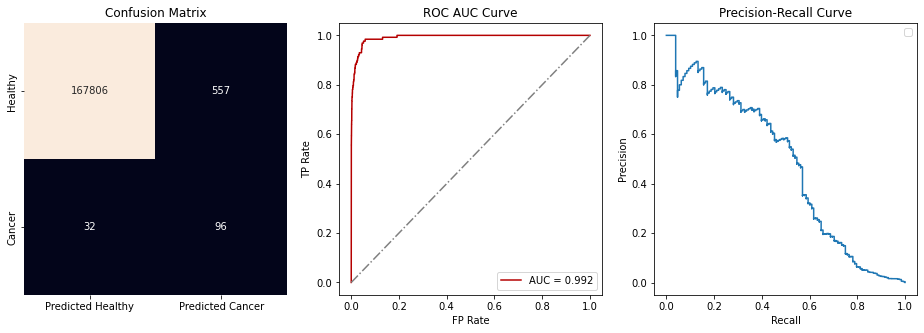

In [3]:
single_cv_analytics_util = load_cv_analytics_util_see_stats('experiment_participants_screened_single_first_5_XGBClassifier_for_cancer_in_next_1_years_15_trials')

In [4]:
single_test_cols = single_cv_analytics_util.analytics_utils[0].data_util.test_df.columns.to_list()

In [5]:
len(single_test_cols)

175

In [6]:
id_col = 'index'
label = 'cancer_in_next_1_years'
id_and_confidence = []
for analytics_util in single_cv_analytics_util.analytics_utils:
    X_test = analytics_util.data_util.test_df[[id_col, 'plco_id', label]]
    X_test_mismatch = X_test.copy()
    y_pred, y_prob = analytics_util.get_predictions() 
    X_test_mismatch[f'{label}_pred'] = y_pred
    X_test_mismatch[f'{label}_prob'] = y_prob
    X_test_mismatch = X_test_mismatch[X_test_mismatch[label] != X_test_mismatch[f'{label}_pred']]
    X_test_mismatch = X_test_mismatch[X_test_mismatch[label] == 1]
    id_and_confidence.append(X_test_mismatch)
mid_conf_predictions = pd.concat(id_and_confidence)



Cross-Validation measures:
+--------------------+-----------+-------------+-----------+----------+
|                    |      mean |         std |       min |      max |
|--------------------+-----------+-------------+-----------+----------|
| precision__class_0 | 0.999639  | 0.000227844 | 0.999016  | 0.999911 |
| recall__class_0    | 0.9957    | 0.00110053  | 0.994319  | 0.997449 |
| f1-score__class_0  | 0.997665  | 0.000569102 | 0.996875  | 0.998547 |
| precision__class_1 | 0.0893576 | 0.0542384   | 0.0153846 | 0.230769 |
| recall__class_1    | 0.528722  | 0.21924     | 0.153846  | 0.833333 |
| f1-score__class_1  | 0.149498  | 0.0816074   | 0.028169  | 0.339623 |
| accuracy           | 0.995343  | 0.001133    | 0.99377   | 0.997098 |
| auc                | 0.962204  | 0.0279664   | 0.898491  | 0.994263 |
+--------------------+-----------+-------------+-----------+----------+


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


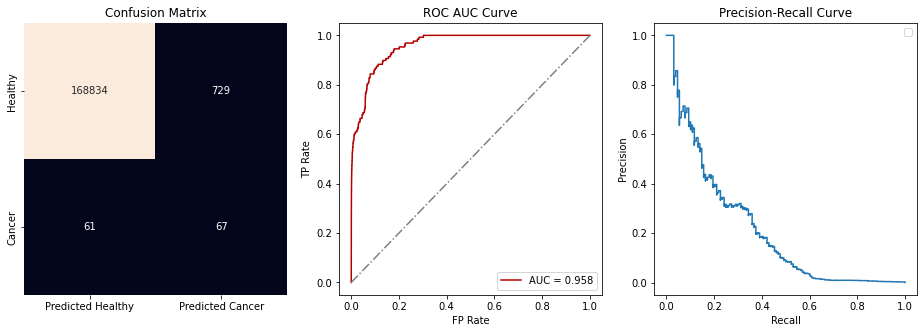

In [7]:
cv_analytics_util = load_cv_analytics_util_see_stats('experiment_participants_screened_first_5_XGBClassifier_for_cancer_in_next_1_years_15_trials')



Cross-Validation measures:
+--------------------+------------+-------------+------------+-----------+
|                    |       mean |         std |        min |       max |
|--------------------+------------+-------------+------------+-----------|
| precision__class_0 | 0.999757   | 0.000175895 | 0.999346   | 1         |
| recall__class_0    | 0.944383   | 0.0052124   | 0.936023   | 0.952686  |
| f1-score__class_0  | 0.971274   | 0.00272901  | 0.966822   | 0.975458  |
| precision__class_1 | 0.00953599 | 0.00452744  | 0.00298507 | 0.0209424 |
| recall__class_1    | 0.692462   | 0.178674    | 0.4        | 1         |
| f1-score__class_1  | 0.0187772  | 0.00882117  | 0.00593472 | 0.0408859 |
| accuracy           | 0.944194   | 0.00515863  | 0.935792   | 0.952118  |
| auc                | 0.962204   | 0.0279664   | 0.898491   | 0.994263  |
+--------------------+------------+-------------+------------+-----------+


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


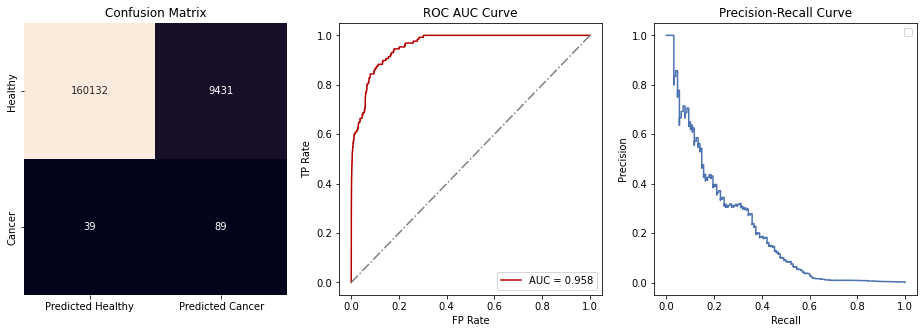

In [30]:
cv_analytics_util.update_thresholds(0.03)
cv_analytics_util.get_cv_report();
cv_analytics_util.display_graph()

In [8]:
test_cols = cv_analytics_util.analytics_utils[0].data_util.test_df.columns.to_list()

In [9]:
for col in test_cols:
    if col not in single_test_cols:
        print(col)

In [10]:
from oop_functions.util_functions import summarize_features, print_df, convert_numeric_to_float16

processed_data = pd.read_csv('./processed_dataset/recent_propagated_dataset.csv', index_col=0)
processed_data = convert_numeric_to_float16(processed_data)

In [11]:

processed_data['ca125ii_level_binary'] = np.nan
processed_data.loc[processed_data['ca125ii_level'] < 35, 'ca125ii_level_binary'] = 1
processed_data.loc[processed_data['ca125ii_level'] >= 35 , 'ca125ii_level_binary'] = 2

(11270, 175)
(11237, 175)
(11314, 175)
(11244, 175)
(11250, 175)
(11238, 175)
(11311, 175)
(11229, 175)
(11271, 175)
(11204, 175)
(11230, 175)
(11221, 175)
(11294, 175)
(11190, 175)
(11237, 175)


Cross-Validation measures:
+--------------------+------------+-------------+------------+------------+
|                    |       mean |         std |        min |        max |
|--------------------+------------+-------------+------------+------------|
| precision__class_0 | 0.999818   | 0.000144079 | 0.999495   | 1          |
| recall__class_0    | 0.879847   | 0.0056192   | 0.86953    | 0.886442   |
| f1-score__class_0  | 0.935995   | 0.00317779  | 0.93008    | 0.939803   |
| precision__class_1 | 0.00496832 | 0.00091907  | 0.00309358 | 0.00621601 |
| recall__class_1    | 0.793519   | 0.160421    | 0.444444   | 1          |
| f1-score__class_1  | 0.00987441 | 0.00182676  | 0.00614439 | 0.0123552  |
| accuracy           | 0.879778   | 0.00560258  | 0.869356   | 0.886523   |
| auc           

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


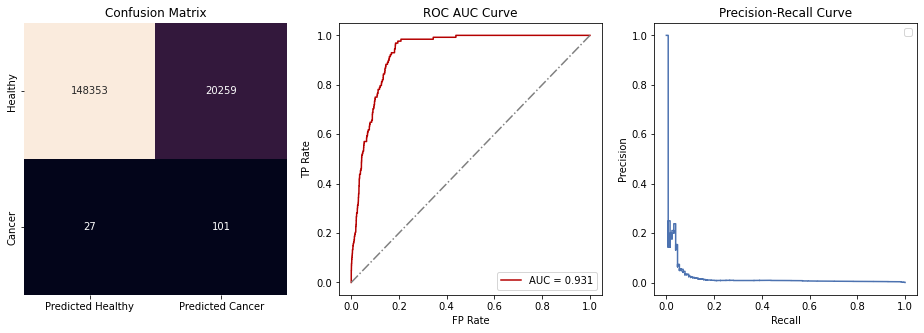

In [27]:
# Create a copy of the whole dataset
label = 'cancer_in_next_1_years'
full_dataset = []
for analytics_util in cv_analytics_util.analytics_utils:
    X_test = analytics_util.data_util.test_df
    full_dataset.append(X_test.copy())
full_dataset = pd.concat(full_dataset)
processed_data = processed_data[full_dataset.columns]
full_dataset = processed_data[processed_data[id_col].isin(full_dataset[id_col])]
# Add those records to the test datasets of the single label dataset and test its validity
for analytics_util in single_cv_analytics_util.analytics_utils:
    idx = analytics_util.data_util.test_df['plco_id'].to_list()
    print((full_dataset[full_dataset['plco_id'].isin(idx)].shape))
    analytics_util.data_util.test_df = full_dataset[full_dataset['plco_id'].isin(idx)]
    analytics_util.data_util.test_df = analytics_util.data_util.imputer.imputer_transform(analytics_util.data_util.test_df)
single_cv_analytics_util.update_thresholds(0.2)
single_cv_analytics_util.get_cv_report();
single_cv_analytics_util.display_graph()

In [13]:
id_col = 'index'
label = 'cancer_in_next_1_years'
id_and_confidence = []
for analytics_util in cv_analytics_util.analytics_utils:
    X_test = analytics_util.data_util.test_df[[id_col, 'plco_id', label]]
    X_test_mismatch = X_test.copy()
    y_pred, y_prob = analytics_util.get_predictions() 
    X_test_mismatch[f'{label}_pred'] = y_pred
    X_test_mismatch[f'{label}_prob'] = y_prob
    X_test_mismatch = X_test_mismatch[X_test_mismatch[label] != X_test_mismatch[f'{label}_pred']]
    X_test_mismatch = X_test_mismatch[X_test_mismatch[label] == 1]
    id_and_confidence.append(X_test_mismatch)
mid_conf_predictions_2 = pd.concat(id_and_confidence)

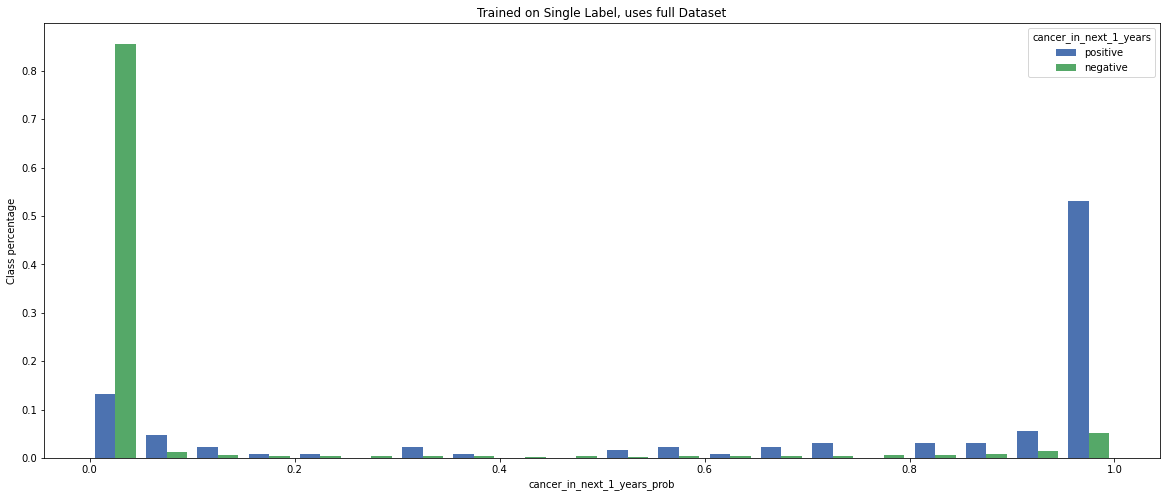

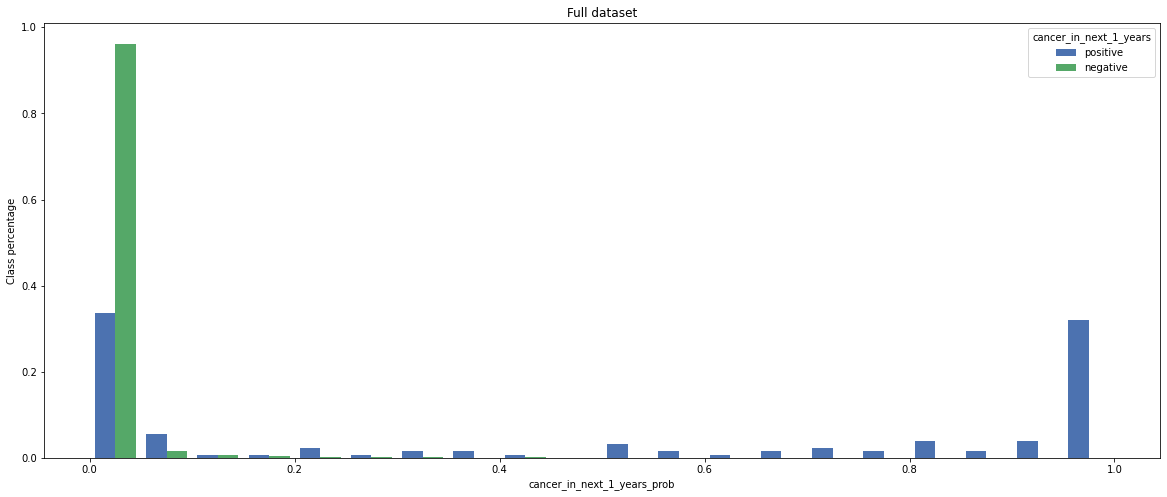

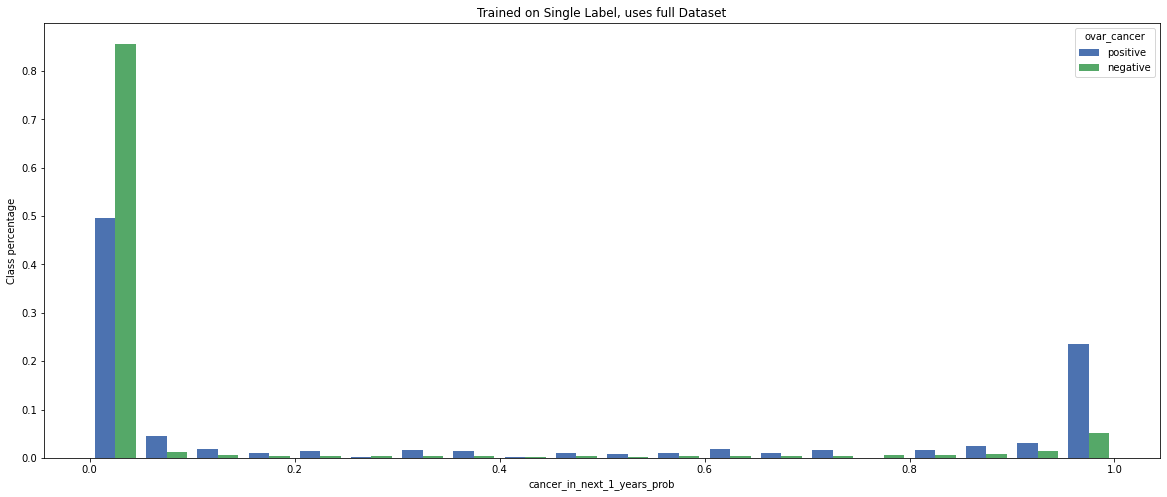

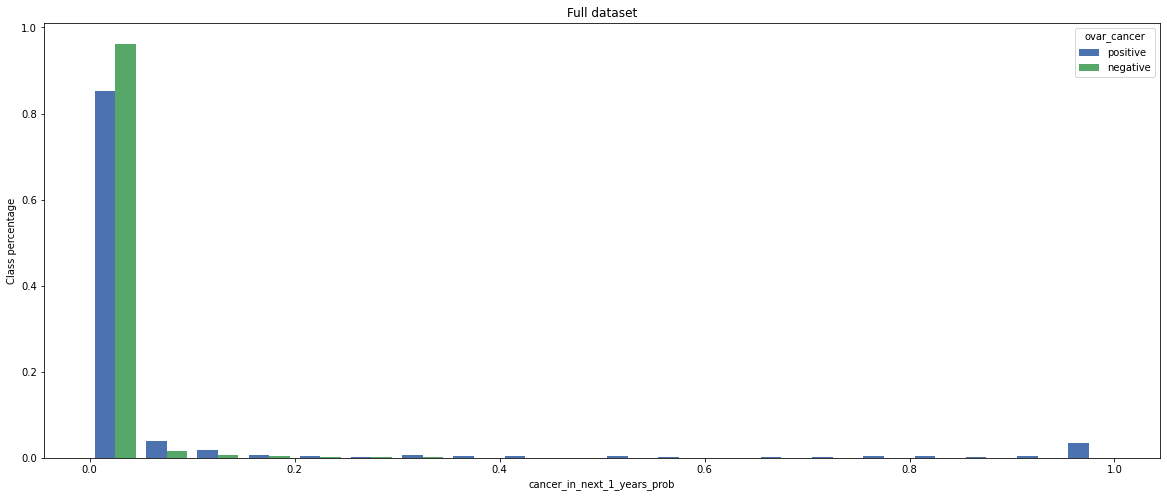

In [32]:

full_dataset = get_dataset_with_predictions(single_cv_analytics_util, id_col = 'index', label = 'cancer_in_next_1_years')
plot_hist_side_by_side_for_class(full_dataset, 'cancer_in_next_1_years', 'cancer_in_next_1_years_prob', normalize = True, title='Trained on Single Label, uses full Dataset')
full_dataset = get_dataset_with_predictions(cv_analytics_util, id_col = 'index', label = 'cancer_in_next_1_years')
plot_hist_side_by_side_for_class(full_dataset, 'cancer_in_next_1_years', 'cancer_in_next_1_years_prob', normalize = True, title='Full dataset')

full_dataset = get_dataset_with_predictions(single_cv_analytics_util, id_col = 'index', label = 'cancer_in_next_1_years')
plot_hist_side_by_side_for_class(full_dataset, 'ovar_cancer', 'cancer_in_next_1_years_prob', normalize = True, title='Trained on Single Label, uses full Dataset')
full_dataset = get_dataset_with_predictions(cv_analytics_util, id_col = 'index', label = 'cancer_in_next_1_years')
plot_hist_side_by_side_for_class(full_dataset, 'ovar_cancer', 'cancer_in_next_1_years_prob', normalize = True, title='Full dataset')